<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (WIP) 08. PyTorch Paper Replicating

TK intro

Want to recreate ViT paper: "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" - https://arxiv.org/abs/2010.11929 - TK will refer to this as "ViT paper" throughout.

* TK what is ViT?

* TK - The name Transformer comes from the architecture name in the paper where it was originally introduced, [*Attention is all you need*](https://arxiv.org/abs/1706.03762). An architecture is usually considered a Transformer variant if it uses attention layers in a specific pattern. Since the Transformer architecture originally focused on text data, the goal of the ViT paper was to bring it to the vision.

* TK - The original transformer was made to work on sequences of text (1D), Vision Transformer turns images into sequences of "patches".

* TK - original ViT also called "vanilla vision transformer"

## TK - What is paper replicating?

It's no secret machine learning is advancing fast.

Many of these advances get published in machine learning research papers.

And the goal of **paper replicating** is to take replicate these advances with code so you can use the techniques for your own problem.

For example, let's say a new model architecture gets released that performs better than any other architecture before on various benchmarks, wouldn't it be nice to try that architecture on your own problems?

* TK image: paper replicating = research paper (language + diagrams + math) -> code (turn language, diagrams and math into usable code) / (translate a research paper into usable code)

## TK - What is a machine learning research paper?

A machine learning research paper is a scientific paper that details findings of a research group on a specific area.

The contents of a machine learning research paper can vary from paper to paper but they generally follow the structure:

| **Section** | **Contents** |
| ----- | ----- | 
| **Abstract** | An overview/summary of the paper's main findings/contributions. |
| **Introduction** | What's the paper's main problem and what are previous methods used to try and solve it? |
| **Method** | How did the researchers go about conducting their research? For example, what model(s) were used, data sources, training setups, etc. |
| **Results** | What are the outcomes of the paper? If a new type of model or training setup was used, how did the results of findings compare to previous works (this is where **experiment tracking** comes in handy)? |
| **Conclusion** | What are the limitations of the suggested methods? What are some next steps for the research community? |
| **References** | What resources/other papers did the researchers look at to build their own body of work? |
| **Appendix** | Are there any extra resources/findings to look at that weren't included in any of the above sections? |

## TK - Why replicate a machine learning research paper?

A machine learning research paper is often a presentation of months of work and experiments done by some of the best machine learning teams in the world condensed into a few pages of text.

And if these experiments lead to better results in an area related to the problem you're working on, it'd be nice to them out.

Also, replicating the work of others is a fantastic way to practice your skills.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-george-hotz-quote.png" width=600 alt="george hotz quote saying to get better at being a machine learning engineer, download a paper, implement it and keep going until you have skills"/>

*George Hotz is founder of [comma.ai](https://comma.ai/), a self-driving car company and livestreams machine learning coding on [Twitch](https://www.twitch.tv/georgehotz) and those videos get posted in full to [YouTube](https://www.youtube.com/c/georgehotzarchive). I pulled this quote from one of his livestreams. The "٭" is to note that machine learning engineering often involves the extra step(s) of preprocessing data and making your models available for others to use (deployment).*
    
When you first start trying to replicate research papers, you'll likely be overwhelmed.

That's normal.

Research teams spend weeks, months and sometimes years creating these works so it makes sense if it takes you sometime to even read let alone reproduce the works.

Replicating research is such a tough problem, phenomenal machine learning libraries and tools such as, [HuggingFace](https://huggingface.co/), [PyTorch Image Models](https://github.com/rwightman/pytorch-image-models) (`timm` library) and [fast.ai](https://www.fast.ai/) have been born out of making machine learning research more accessible. 

## TK - Where can you find code examples for machine learning research papers?

One of the first things you'll notice when it comes to machine learning research is: there's a lot of it.

So beware, trying to stay on top of it is like trying to outrun a hamster wheel.

Follow your interest, pick a few things that stand out to you.

In saying this, there are several places to find and read machine learning research papers:
* [arXiv](https://arxiv.org/) - Pronounced "archive", arXiv is a free and open resource for reading technical articles on everything from physics to computer science (inlcuding machine learning).
* [Papers with Code](https://paperswithcode.com/) - A curated collection of trending, active and greatest machine learning papers, many of which include code resources attached. Also includes a collection of common machine learning datasets, benchmarks and current state-of-the-art models.
* [AK Twitter](https://twitter.com/ak92501) - The AK Twitter account publishes machine learning research highlights, often with live demos almost every day. I don't understand 9/10 posts but I find it fun to explore every so often.
* [lucidrains' `vit-pytorch` GitHub repository](https://github.com/lucidrains/vit-pytorch) - Less of a place to find research papers and more of an example of what paper replicating with code on a larger-scale looks like. The `vit-pytorch` repository is a collection of Vision Transformer model architectures from various research papers replicated with PyTorch code (much of the inspiration for this notebook was gathered from this repository). 

TK image: showcase the above

## TK - What we're going to cover

TODO

* ViT -> FoodVision Mini
* Layers = collections of functions to manipulate data -> Architectures = collections of layers (blocks) -> All layers (and blocks) have inputs and outputs
    * Replicating research papers starts by figuring out the inputs and outputs of your layers -> blocks -> model 

## TK - Where can you get help?

All of the materials for this course [are available on GitHub](https://github.com/mrdbourke/pytorch-deep-learning).

If you run into trouble, you can ask a question on the course [GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

And of course, there's the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch. 

## TK 0. Getting setup 

As we've done previously, let's make sure we've got all of the modules we'll need for this section.

We'll import the Python scripts (such as `data_setup.py` and `engine.py`) we created in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).

To do so, we'll download [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the `pytorch-deep-learning` repository (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. 

`torchinfo` will help later on to give us a visual representation of our model.

And since later on we'll be using a newer version of the `torchvision` package (as of June 2022), we'll make sure we've got the latest versions.

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.0+cu102
torchvision version: 0.13.0+cu102


> **Note:** If you're using Google Colab, you may have to restart your runtime after running the above cell. After restarting, you can run the cell again and verify you've got the right versions of `torch` and `torchvision`.

Now we'll continue with the regular imports, setting up device agnostic code and this time we'll also get the [`helper_functions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py) script from GitHub.

The `helper_functions.py` script contains several functions we created in previous sections:
* `set_seeds()` to set the random seeds (created in [07. PyTorch Experiment Tracking section 0](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#create-a-helper-function-to-set-seeds)).
* `download_data()` to download a data source given a link (created in [07. PyTorch Experiment Tracking section 1](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#1-get-data)).
* `plot_loss_curves()` to inspect our model's training results (created in [04. PyTorch Custom Datasets section 7.8](https://www.learnpytorch.io/04_pytorch_custom_datasets/#78-plot-the-loss-curves-of-model-0))

> **Note:** It may be a better idea for many of the functions in the `helper_functions.py` script to be merged into `going_modular/going_modular/utils.py`, perhaps that's an extension you'd like to try.


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## TK 1. Get Data

Since we're continuing on with FoodVision Mini, let's download the pizza, steak and sushi image dataset we've been using.

To do so we can use the `download_data()` function from `helper_functions.py` that we created in [07. PyTorch Experiment Tracking section 1](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#1-get-data).

We'll `source` to the raw GitHub link of the [`pizza_steak_sushi.zip` data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip) and the `destination` to `pizza_steak_sushi`.

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

Beautiful! Data downloaded, let's setup the training and test directories.

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## TK 2. Create Datasets and DataLoaders

Since we've got some data, let's now turn it into `DataLoader`'s.

To do so we can use the `create_dataloaders()` function in [`data_setup.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/data_setup.py).

First, we'll create a transform to prepare our images.

This where one of the first references to the ViT paper will come in.

In Table 3, the training resolution is mentioned as being 224 (height=224, width=224). 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-image-size-and-batch-size.png" width=900 alt="Table 3 from the Vision Transformer paper showing the image size and batch size"/>

*You can often find various hyperparameter settings listed in a table. In this case we're still preparing our data, so we're mainly concerned with things like image size and batch size. Source: Table 3 in [ViT paper](https://arxiv.org/abs/2010.11929).*

So we'll make sure our transform resizes our images appropriately.

And since we'll be training our model from scratch (no transfer learning to begin with), we won't provide a `normalize` transform like we did in [06. PyTorch Transfer Learning section 2.1](https://www.learnpytorch.io/06_pytorch_transfer_learning/#21-creating-a-transform-for-torchvisionmodels-manual-creation).

### 2.1 Prepare transforms for images

In [7]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


### 2.2 Turn images into `DataLoader`'s
Transforms created!

Let's now create our `DataLoader`'s.

The ViT paper states the use of a batch size of 4096 which is 128x the size of the batch size we've been using (32).

We're going to stick with a batch size of 32.

Why?

Because some hardware (including the free tier of Google Colab) may not be able to handle a batch size of 4096.

Having a batch size of 4096 means that 4096 images need to fit into the GPU memory at a time.

This works when you've got the hardware to handle it like a research team from Google often does but when you're running on a single GPU (such as using Google Colab), making sure things work with smaller batch size first is a good idea.

An extension of this project could be to try a higher batch size value and see what happens.

> **Note:** We're using the `pin_memory=True` parameter in the `create_dataloaders()` function to speed up computation. `pin_memory=True` avoids unnecessary copying of memory between the CPU and GPU memory by "pinning" examples that have been seen before. For more on this concept. Though the benefits of this will likely be seen with larger dataset sizes (our FoodVision Mini dataset is quite small). See the PyTorch [`torch.utils.data.DataLoader` documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) or [Making Deep Learning Go Brrrr from First Principles](https://horace.io/brrr_intro.html) by Horace He for more.

In [8]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fa8cc731550>,
 ['pizza', 'steak', 'sushi'])

### TK 2.3 Visualize a single image

Now we've loaded our data, let's *visualize, visualize, visualize!*

An important step in the ViT paper is preparing the images into patches.

We'll get to what this means in a second but for now, let's view a single image and its label.

To do so, let's get a single image and label from a batch of data and inspect their shapes.

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

Wonderful!

Now let's plot the image and its label with `matplotlib`. 

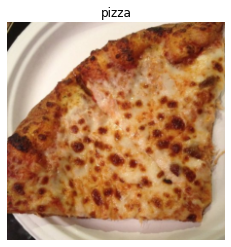

In [10]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

Nice!

Looks like our images are importing correctly, let's continue with the paper replication.

## TK 3. Replicating the ViT paper: an overview

Before we write anymore code, let's discuss what we're doing.

We'd like to replicate the ViT paper for our own problem, FoodVision Mini.

So our inputs are: images of pizza, steak and sushi.

And our ideal model outputs are: predicted labels of pizza, steak or sushi.

No different to what we've been doing throughout the previous sections.

The question is: how do we go from our inputs to the desired outputs?

### 3.1 Inputs and outputs, layers and blocks

ViT is a deep learning neural network architecture.

And any neural network architecture is generally comprised of **layers**.

And a collection of layers is often referred to as a **block**.

And stacking many blocks together is what gives us the whole architecture.

A **layer** takes an input (say an image tensor), performs some kind of function on it (for example what's in the layer's `forward()` method) and then returns an output.

So if a **single layer** takes an input and gives an output, then a collection of layers or a **block** also takes an input and gives an output.

Let's make this concrete:
* **Layer** - takes an input, performs a function on it, returns an output.
* **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

This ideology is what we're going to be using to replicate the ViT paper.

We're going to take it layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

The reason we do this is because looking at a whole research paper can be intimidating.

So for a better understanding, we'll break it down, starting with the inputs and outputs of single layer and working up to the inputs and outputs of the whole model.

TK image: stacking the network together like lego (functions + layers + blocks = model).

### 3.2 Getting specific: What's ViT made of?

There are many little details about the ViT model sprinkled throughout the paper.

Finding them all is like one big treasure hunt!

Remember, a research paper is often months of work compressed into a few pages so it's understandable for it to take of practice to replicate.

However, the main three resources we'll be looking at for the architecture design are:
1. **Figure 1** - This gives an overview of the model in a graphical sense, you could *almost* recreate the architecture with this figure alone.
2. **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

#### TK 3.2.1 Exploring Figure 1

Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:
1. **Layers** - takes an **input**, performs an operation or function, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.* 

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and add a position number what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1). 
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

This is because of how PyTorch is designed, it's one of the main purposes of PyTorch to create reusable neural network layers for both researchers and machine learning practitioners.

> **Question:** Why not code everything from scratch?
>
> You could definitely do that by reproducing all of the math equations from the paper with custom PyTorch layers and that would certainly be an educative exercise, however, using pre-existing PyTorch layers is usually favoured as pre-existing layers have often been extensively tested and performance checked to make sure they run correctly and fast. 

> **Note:** We're going to focused on write PyTorch code to create these layers, for the background on what each of these layers does, I'd suggest reading the ViT Paper in full or reading the linked resources for each layer.

Let's take Figure 1 and adapt it to our FoodVision Mini problem of classifying images of food into pizza, steak or sushi.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

*Figure 1 from the ViT Paper adapted for use with FoodVision Mini. An image of food goes in (pizza), the image gets turned into patches and then projected to an embedding. The embedding then travels through the various layers and blocks and (hopefully) the class "pizza" is returned.*

#### TK - 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

*These four equations represent the math behind the four major parts of the ViT architecture.*

Section 3.1 describes each of these (some of the text has been omitted for brevity, bolded text is mine):

| **Equation number** | **Description from ViT paper section 3.1** | 
| ----- | ----- | 
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**. |
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | See above. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |

Let's map these descriptions to the ViT architecture in Figure 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

*Connecting Figure 1 from the ViT paper to the four equations from section 3.1 describing the math behind each of the layers/blocks. Some details such as "residual connections after every block" are referred to in Figure 1 and in the text but not in the equations.*

There's a lot happening in the image above but following the coloured lines and arrows reveals the main concepts of the ViT architecture.

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer)
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z)
3. $\mathbf{z}_{\ell}$ is "z of a particular layer"

And $\mathbf{y}$ is the overall output of the architecture.

**Equation 1**

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

TK - update the vector form to reflect a real exmaple

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

Where each of the elements in the vector is learnable (their `requires_grad=True`).

**Equation 2**

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the "MSA block".

In pseudocode, this might look like: 

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

**Equation 3**

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like: 

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

**Equation 4**

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```python
y = LN_layer(Linear_layer(x_output_MLP_block[0]))
```

Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

> **Note:** The above section covers alot of information. But don't forget if something doesn't make sense, you can always research it further. By asking questions like "what is a residual connection?".

#### TK - 3.2.3 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture. 

### TK - 3.3 My workflow for replicating papers

When I start working on replicating a paper, I go through the following steps:

1. Read the whole paper end-to-end once (to get an idea of the main concepts).
2. Go back through each section and see how they line up with each other and start thinking about how they might be turned into code (just like above).
3. Repeat step 2 until I've got a fairly good outline.
4. Use [mathpix.com](https://mathpix.com/) (a very handy tool) to turn any sections of the paper into markdown/LaTeX to put into notebooks.
5. Replicate the simplest version of the model possible.
6. If I get stuck, look up other examples.

TK - gif of mathpix

We've already gone through the first few steps above (and if you haven't read the full paper yet, I'd encourage you to give it a go) but what we'll be focusing on next is step 5: replicating the simplest version fo the model possible.

This is why we're starting with ViT-Base.

Replicating the smallest version of the architecture possible, get it working and then we can scale up if we wanted to.

> **Note:** If you've never read a research paper before, many of the above steps can be intimidating. But don't worry, like anything, your skills at reading *and* replicating papers will improve with practice. Don't forget, a research paper is often *months* of work by many people compressed into a few pages. So trying to replicate it on your own is no small feat. 

## TK 4. Equation 1: Split data into patches and creating the class, position and patch embedding 

I remember one of my machine learning engineer friends used to say "it's all about the embedding."

As in, if you can represent your data in a good, learnable way (as embeddings are learnable representations), chances are a learning algorithm will be able to perform well on them.

So with that being said, let's start by creating the class, position and patch embeddings for the ViT architecture.

We'll start with the **patch embedding**.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

Recall that an **embedding** is a learnable representation of some form and is often a vector. The term learnable is important because this means the representation of an input image can be improved and learned over time.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

And size we're dealing with image shapes, let's keep in mind the line from Table 3 of the ViT paper: 

> Training resolution is **224**.

Let's break down the text above.

* $D$ is the size of the **patch embeddings**, different values for $D$ can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(H, W)$ is the resolution of the original image.
    * $C$ is the number of channels.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png" width=900 alt="mapping the vit architecture diagram positional and patch embeddings portion to the relative mathematical equation describing what's going on"/>

*Mapping the patch and position embedding portion of the ViT architecture from Figure 1 to Equation 1. The opening paragraph of section 3.1 describes the different input and output shapes of the patch embedding layer.*

### TK - 4.1 Calculating patch embedding input and output shapes by hand

How about we start by calculating these input and output shape values by hand?

To do so, let's create some variables to mimic each of the terms (such as $H$, $W$ etc) above.

We'll use a patch size ($P$) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).

In [11]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


We've got the number of patches, how about we create the image output size as well?

Better yet, let's replicate the input and output shapes of the patch embedding layer.

Recall:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [12]:
# Input shape
input_shape = (height, width, color_channels)

# Output shape
output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (2D image): {input_shape}")
print(f"Output shape (flattened 2D patches): {output_shape}")

Input shape (2D image): (224, 224, 3)
Output shape (flattened 2D patches): (196, 768)


Input and output shapes acquired!

### TK - 4.2 Turning a single image into patches

Now we know the ideal input and output shapes for our **patch embedding** layer.

What we're doing here is breaking the overall architecture down into smaller pieces, focusing on the inputs and outputs of individual layers.

So how do we create the patch embedding layer?

We'll get to that shortly, first, let's *visualize, visualize, visualize!* what it looks like to turn an image into patches.

Let's start with our single image.

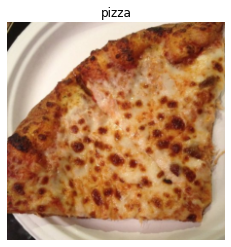

In [13]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

We want to turn this image into patches of itself inline with Figure 1 of the ViT paper.

How about we start by just visualizing the top row of patched pixels?

We can do this by indexing on the different image dimensions.

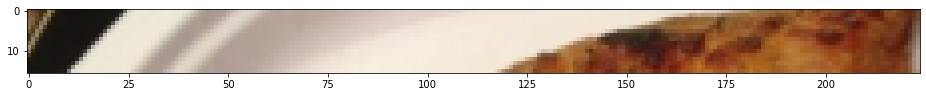

In [14]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Now we've got the top row, let's turn it into patches.

We can do this by iterating through the number of patches there'd be in the top row. 

Number of patches per row: 14.0


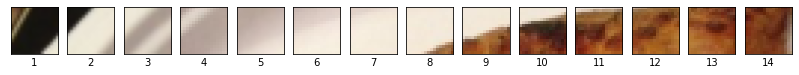

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Those are some nice looking patches!

How about we do it for the whole image?

This time we'll iterate through the indexs for height and width and plot each patch as it's own subplot.

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0


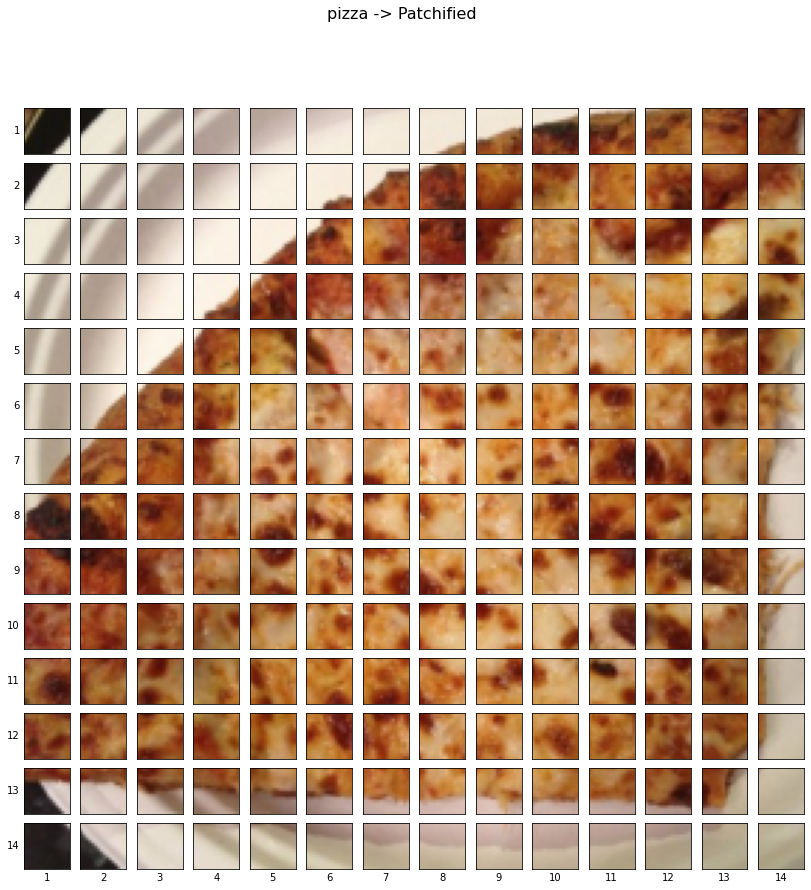

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nNumber of patches per column: {num_patches}\nTotal patches: {num_patches*num_patches}")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Image patchified!

Woah, that looks cool.

Now how do we turn each of these patches into an embedding and convert them into a sequence?

Hint: we can use PyTorch layers. Can you guess which?

### TK - 4.3 Creating image patches with `torch.nn.Conv2d()`

It's time to start moving towards replicating the patch embedding layers with PyTorch.

To visualize our single image we wrote code to loop through the different height and width dimensions of a single image and plot individual patches.

This operation is very similar to the convolutional operation we saw in [03. PyTorch Computer Vision section 7.1: Stepping through `nn.Conv2d()`](https://www.learnpytorch.io/03_pytorch_computer_vision/#71-stepping-through-nnconv2d).

In fact, the authors of the ViT paper mention in section 3.1 that the patch embedding is achievable with a convolutional neural network (CNN):  

> **Hybrid Architecture.** As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a **CNN feature map**. As a special case, the patches can have spatial size $1 \times 1$, which means that the **input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension**. The classification input embedding and position embeddings are added as described above.

The "**feature map**" they're refering to are the weights/activations produced by a convolutional layer passing over a given image.

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-patch-embedding-animation.gif" width=900 alt="example of creating a patch embedding by passing a convolutional layer over a single image"/>

*By setting the `kernel_size` and `stride` parameters of a [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer equal to the `patch_size`, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.* 

Remember our ideal input and output shapes for the patch embedding layer?

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Or for an image size of 224 and patch size of 16:

* **Input (2D image):** (224, 224, 3) 
* **Output (flattened 2D patches):** (196, 768)

We can recreate these with:
* [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for turning our image into patches of CNN feature maps.
* [`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) for flattening the spatial dimensions of the feature map.

Let's start with the `torch.nn.Conv2d()` layer.

We can replicate the creation of patches by setting the `kernel_size` and `stride` equal to `patch_size`.

This means each convolutional kernel will be of size `(patch_size x patch_size)` or if `patch_size=16`, `(16 x 16)` (the equivalent of one whole patch) 

And each step or `stride` of the convolutional kernel will be `patch_size` pixels long or `16` pixels long (equivalent of stepping to the next patch).

We'll set `in_channels=3` for the number of color channels in our image and we'll set `out_channels=768`, the same as the $D$ value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a vector of size 768).

In [17]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

Now we've got a convoluational layer, let's see what happens when we pass a single image through it.

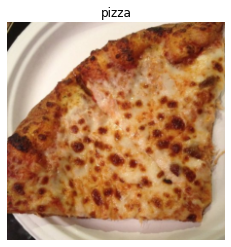

In [18]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [19]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Passing our image through the convolutional layer turns it into a series of 768 (this is the embedding size or $D$) feature/activation maps.

So its output shape can be read as:
    
```python
torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Let's visualize five random feature maps and see what they look like.

Showing random convolutional feature maps from indexes: [180, 39, 286, 72, 105]


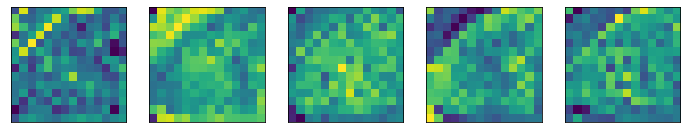

In [20]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

Notice how the feature maps all kind of represent the original image, visualizing a few you can see the different major outlines and some major features.

The important thing to note is that these features may change over time as the neural network learns.

And because of these, these feature maps can be considered a **learnable embedding** of our image.

Let's check one out in numerical form.

In [21]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.2642, 1.1367, 1.0221, 0.9712, 1.0950, 1.2478, 1.2884, 1.1481,
           0.9640, 0.6204, 0.5996, 0.5855, 0.5560, 0.4992],
          [1.1578, 1.0633, 0.9593, 1.1931, 1.3194, 1.1306, 0.7317, 0.4322,
           0.6025, 0.7246, 0.7891, 0.5383, 0.4786, 0.7098],
          [1.0163, 0.9368, 1.1675, 1.3373, 1.0429, 0.7497, 0.7445, 0.4270,
           0.7430, 0.8750, 0.6105, 0.5147, 1.0207, 0.7852],
          [1.0669, 1.0157, 1.3291, 1.0117, 0.4848, 0.6802, 0.8365, 0.7736,
           0.8618, 0.9144, 0.8926, 0.9795, 0.7475, 0.7585],
          [0.9371, 1.1937, 1.0068, 0.6377, 0.7283, 0.9625, 1.0372, 0.8920,
           0.9372, 0.9034, 0.9683, 0.9405, 0.5958, 0.8740],
          [0.9419, 0.8599, 0.5429, 0.6954, 1.0202, 0.9093, 1.0003, 0.7619,
           0.8472, 0.8062, 0.6418, 0.7741, 0.5791, 0.9816],
          [0.7965, 0.7202, 0.6424, 0.9137, 0.8264, 1.0243, 1.0920, 0.9548,
           0.9166, 0.7937, 0.4675, 0.5346, 0.7774, 1.1001],
          [0.3298, 0.4832, 0.5324, 0.7486, 0.8303, 0.81

The `grad_fn` output of the `single_feature_map` and the `required_grad=True` attribute means PyTorch is tracking the gradients of this feature map and it will be updated by gradient descent during training. 

### TK - 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

We've turned our image into patch embeddings but they're still in 2D format.

How do we get them into the desired output shape of the patch embedding layer of the ViT model?

* **Desried output (flattened 2D patches):** (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$

Let's check the current shape.

In [22]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


Well we've got the 768 part ( $(P^{2} \cdot C)$ ) but we still need the number of patches ($N$).

Reading back through section 3.1 of the ViT paper it says (bold mine):

> As a special case, the patches can have spatial size $1 \times 1$, which means that the **input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension**.

Flattening the spatial dimensions of the feature map hey?

What layer do we have in PyTorch that can flatten?

How about [`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html )?

But we don't want to flatten the whole tensor, we only want to flatten the "spatial dimensions of the feature map".

Which in our case is the `feature_map_height` and `feature_map_width` dimensions of `image_out_of_conv`.

So how about we create a `torch.nn.Flatten()` layer to only flatten those dimensions, we can use the `start_dim` and `end_dim` parameters to set that up?

In [23]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Nice! Now let's put it all together!

We'll:
1. Take a single image.
2. Put in through the convolutional layer (`conv2d`) to turn the image into 2D feature maps (patch embeddings).
3. Flatten the 2D feature map into a single sequence.

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


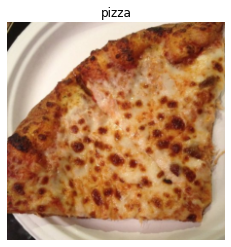

In [24]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Woohoo! It looks like our `image_out_of_conv_flattened` shape is very close to our desired output shape: 
    
* **Desried output (flattened 2D patches):** (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$
* **Current shape:** (1, 768, 196)

The only difference is our current shape has a batch size and the dimensions are in a different order to the desired output.

How could we fix this?

Well, how about we rearrange the dimensions?

We can do so with `torch.Tensor.permute()` just like we do when rearranging image tensors to plot them with matplotlib.

Let's try.

In [25]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


Yes!!!

We've now matched the desired input and output shapes for the patch embedding layer of the ViT architecture using a couple of PyTorch layers.

How about we visualize one of the flattened feature maps?

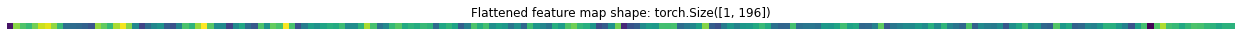

In [26]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

Hmm, the flattened feature map doesn't look like much visually, but that's not what we're concerned about, this is what will be the output of the patching embedding layer and the input to the rest of the ViT architecture.

TK image - single image -> conv2d -> flatten -> get the output above (show the workflow and transformation, this could be the gif we've but using but extended to work with the flatten section)

> **Note:** The [original Transformer architecture](https://arxiv.org/abs/1706.03762) was designed to work with text. The Vision Transformer architecture (ViT) had the goal of using the original Transformer for images. This is why the input to the ViT architecture is processed in the way it is. We're essentially taking a 2D image and formatting it so it appears as a 1D sequence of text. 

How about we view the flattened feature map in tensor form?

In [27]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.2642, 1.1367, 1.0221, 0.9712, 1.0950, 1.2478, 1.2884, 1.1481, 0.9640,
          0.6204, 0.5996, 0.5855, 0.5560, 0.4992, 1.1578, 1.0633, 0.9593, 1.1931,
          1.3194, 1.1306, 0.7317, 0.4322, 0.6025, 0.7246, 0.7891, 0.5383, 0.4786,
          0.7098, 1.0163, 0.9368, 1.1675, 1.3373, 1.0429, 0.7497, 0.7445, 0.4270,
          0.7430, 0.8750, 0.6105, 0.5147, 1.0207, 0.7852, 1.0669, 1.0157, 1.3291,
          1.0117, 0.4848, 0.6802, 0.8365, 0.7736, 0.8618, 0.9144, 0.8926, 0.9795,
          0.7475, 0.7585, 0.9371, 1.1937, 1.0068, 0.6377, 0.7283, 0.9625, 1.0372,
          0.8920, 0.9372, 0.9034, 0.9683, 0.9405, 0.5958, 0.8740, 0.9419, 0.8599,
          0.5429, 0.6954, 1.0202, 0.9093, 1.0003, 0.7619, 0.8472, 0.8062, 0.6418,
          0.7741, 0.5791, 0.9816, 0.7965, 0.7202, 0.6424, 0.9137, 0.8264, 1.0243,
          1.0920, 0.9548, 0.9166, 0.7937, 0.4675, 0.5346, 0.7774, 1.1001, 0.3298,
          0.4832, 0.5324, 0.7486, 0.8303, 0.8101, 0.9969, 0.9931, 1.0058, 0.6002,
          0.6643

Beautiful!

We've turned our single 2D image into a single 1D learnable embedding vector (or "Linear Projection of Flattned Patches" in Figure 1 of the ViT paper).

### TK - 4.5 Turning the ViT patch embedding layer into a PyTorch module

Time to put everything we've done for creating the patch embedding into a single PyTorch layer.

We can do so by subclassing `nn.Module` and creating a small PyTorch "model" to do all of the steps above.

Specifically we'll:
1. Create a class called `PatchEmbedding` which subclasses `nn.Module` (so it can be used a PyTorch layer).
2. Initialize the class with the parameters `in_channels=3`, `patch_size=16` (for ViT-Base) and `embedding_dim=768` (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using `nn.Conv2d()` (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above). 
5. Define a `forward()` method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture (${N \times\left(P^{2} \cdot C\right)}$).

Let's do it!

In [28]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

`PatchEmbedding` layer created!

Let's try it out on a single image.

In [29]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


Beautiful!

The output shape matches the ideal input and output shapes we'd like to see from the patch embedding layer:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Where:
* $(H, W)$ is the resolution of the original image.
* $C$ is the number of channels.
* $(P, P)$ is the resolution of each image patch (**patch size**).
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.
    
We've now replicated the patch embedding for equation 1 but not the class token/position embedding.

We'll get to these later on.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-replicating-the-patch-embedding-layer.png" width=900 alt="replicating the vision transformer architecture patch embedding layer"/>

*Our `PatchEmbedding` class (right) replicates the patch embedding of the ViT architecture from Figure 1 and Equation 1 from the ViT paper (left). However, the learnable class embedding and position embeddings haven't been created yet. These will come soon.*

Let's now get a summary of our `PatchEmbedding` layer.

In [30]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding
summary(PatchEmbedding(), 
        input_size=random_input_image, # try swapping this for "random_input_image_error" 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### TK 4.6 Creating the class token embedding

Okay we've made the image patch embedding, time to get to work on the class token embedding.

Or $\mathbf{x}_\text {class }$ from equation 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-class-token.png" width=900 alt="class token embedding highlight from the vision transformer paper figure 1 and section 3.1"/>

*Left: Figure 1 from the ViT paper with the "classification token" or `[class]` embedding token we're going to recreate highlighted. Right: Equation 1 and section 3.1 of the ViT paper that relate to the learnable class embedding token.*

Reading the second paragraph of section 3.1 from the ViT paper, we see the following description: 

> Similar to BERT's `[ class ]` token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). 

> **Note:** [BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a `[ class ]` token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.

So we need to "preprend a learnable embedding to the sequence of embedded patches".

Let's start by viewing our sequence of embedded patches tensor (created in 4.5) and its shape.

In [31]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.4923,  0.0265, -0.0909,  ...,  0.1478, -0.0986,  0.2243],
         [-0.9849,  0.3805, -0.3638,  ...,  0.6115, -0.0805,  0.2097],
         [-0.6015,  0.1235, -0.2506,  ...,  0.6307, -0.4673,  0.2756],
         ...,
         [-0.6668,  0.1713, -0.1711,  ...,  0.4699, -0.2881,  0.2599],
         [-0.6983,  0.1949, -0.1884,  ...,  0.5152, -0.3126,  0.2151],
         [-0.6889,  0.1862, -0.1444,  ...,  0.5019, -0.3564,  0.2378]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the `embedding_dimension` ($D$) and then add it to the `number_of_patches` dimension. 

Or in pseudocode:

```python
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
```

Notice the concatenation (`torch.cat()`) happens on `dim=1` (the `number_of_patches` dimension).

Let's create a learnable embedding for the class token.

To do so, we'll get the batch size and embedding dimension shape and then we'll create a `torch.ones()` tensor in the shape `[batch_size, 1, embedding_dimension]`.

And we'll make the tensor learnable by passing it to `nn.Parameter()` with `requires_grad=True`.

In [32]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_patches, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


> **Note:** Here we're only creating the class token embedding as [`torch.ones()`](https://pytorch.org/docs/stable/generated/torch.ones.html) for demonstration purposes, in reality, you'd likely create the class token embedding with [`torch.randn()`](https://pytorch.org/docs/stable/generated/torch.randn.html) (start with a random number). 

See how the `number_of_patches` dimension of `class_token` is `1` since we only want to prepend one class token value to the start of the patch embedding sequence.

Now we've got the class token embedding, let's prepend it to our sequence of image patches, `patch_embedded_image`.

We can so using [`torch.cat()`](https://pytorch.org/docs/stable/generated/torch.cat.html) and set `dim=1` (so `class_token`'s `number_of_patches` dimension is preprended to `patch_embedded_image`'s `number_of_patches` dimension).

In [33]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4923,  0.0265, -0.0909,  ...,  0.1478, -0.0986,  0.2243],
         [-0.9849,  0.3805, -0.3638,  ...,  0.6115, -0.0805,  0.2097],
         ...,
         [-0.6668,  0.1713, -0.1711,  ...,  0.4699, -0.2881,  0.2599],
         [-0.6983,  0.1949, -0.1884,  ...,  0.5152, -0.3126,  0.2151],
         [-0.6889,  0.1862, -0.1444,  ...,  0.5019, -0.3564,  0.2378]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Nice! Learnable class token prepended!

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-prepending-the-learnable-class-token.png" width=900 alt="going from a sequence of patch embeddings, creating a learnable class token and then prepending it to the patch embeddings"/>

*Reviewing what we've done to create the learnable class token, we start with a sequence of image patch embeddings created by `PatchEmbedding()` on single image, we then created a learnable class token with one value for each of the embedding dimensions and then prepended it to the original sequence of patch embeddings. Note: Using `torch.ones()` to create the learnable class token is mostly for demonstration purposes only, in practice, you'd like create it with `torch.randn()`.* 

### TK 4.7 Creating the position embedding 

Well, we've got the class token embedding and the patch embedding, now how might we create the position embedding?

Or $\mathbf{E}_{\text {pos }}$ from equation 1 where $E$ stands for "embedding".

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-position-embeddings.png" width=900 alt="extracting the position embeddings from the vision transformer architecture and comparing them to other sections of the vision transformer paper"/>

*Left: Figure 1 from the ViT paper with the position embedding we're going to recreate highlighted. Right: Equation 1 and section 3.1 of the ViT paper that relate to the position embedding.*

Let's find out more by reading section 3.1 of the ViT paper (bold mine):

> Position embeddings are added to the patch embeddings to retain positional information. We use **standard learnable 1D position embeddings**, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

To start creating the position embeddings, let's view our current embeddings. 

In [34]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4923,  0.0265, -0.0909,  ...,  0.1478, -0.0986,  0.2243],
          [-0.9849,  0.3805, -0.3638,  ...,  0.6115, -0.0805,  0.2097],
          ...,
          [-0.6668,  0.1713, -0.1711,  ...,  0.4699, -0.2881,  0.2599],
          [-0.6983,  0.1949, -0.1884,  ...,  0.5152, -0.3126,  0.2151],
          [-0.6889,  0.1862, -0.1444,  ...,  0.5019, -0.3564,  0.2378]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Equation 1 states that the position embeddings should have the shape $(N + 1) \times D$ where: 
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.
* $D$ is the size of the **patch embeddings**, different values for $D$ can be found in Table 1.

Luckily we've got both of these values already.

So let's make a learnable 1D embedding with `torch.ones()` to create $\mathbf{E}_{\text {pos }}$. 

In [35]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


> **Note:** Only creating the position embedding as `torch.ones()` for demonstration purposes, in reality, you'd likely create the position embedding with `torch.randn()` (start with a random number and improve via gradient descent). 

Position embeddings created!

Let's add them to our sequence of patch embeddings with a prepended class token.

In [36]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5077, 1.0265, 0.9091,  ..., 1.1478, 0.9014, 1.2243],
         [0.0151, 1.3805, 0.6362,  ..., 1.6115, 0.9195, 1.2097],
         ...,
         [0.3332, 1.1713, 0.8289,  ..., 1.4699, 0.7119, 1.2599],
         [0.3017, 1.1949, 0.8116,  ..., 1.5152, 0.6874, 1.2151],
         [0.3111, 1.1862, 0.8556,  ..., 1.5019, 0.6436, 1.2378]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Notice how the values of each of the elements in the embedding tensor increases by 1 (this is because of the position embeddings being created with `torch.ones()`). 

> **Note:** We could put both the class token embedding and position embedding into their own layer if we wanted to. But we'll see later on how they can be incorporated into the overall ViT architecture's `forward()` method.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-patch-embeddings-with-learnable-class-token-and-position-embeddings.png" width=900 alt="patch embeddings with learnable class token and position embeddings"/>

*The workflow we've used for adding the position embeddings to the sequence of patch embeddings and class token. Note: `torch.ones()` only used to create embeddings for illustration purposes, in practice, you'd likely use `torch.randn()` to start with a random number.*

### TK 4.8 Putting it all together: from image to embedding

Alright, we've come a long way in terms of turning our input images into an embedding and replicating equation 1 from section 3.1 of the ViT paper:

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

Let's now put everything together in a single code cell and go from input image ($x$) to output embedding ${z}_0$.

We can do so by:
1. Setting the patch size (we'll use `16` as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing it's shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our `PatchEmbedding` layer.
4. Creating a `PatchEmbedding` layer with a `patch_size=16` and `embedding_dim=768` (from Table 1 for ViT-Base).
5. Passing the single image through the `PatchEmbedding` layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding like in section 4.6. 
7. Prepending the class token emebdding to the patch embeddings created in step 5.
8. Creating a position embedding like in section 4.7.
9. Adding the position embedding to the class token and patch embeddings created in step 7.

We'll also make sure to set the random seeds with `set_seeds()` and print out the shapes of different tensors along the way.

In [37]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


Woohoo!

From a single image to patch and position embeddings in a single cell of code.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-putting-it-all-together.png" width=900 alt="mapping equation 1 from the vision transformer paper to pytorch code"/> 

*Mapping equation 1 from the ViT paper to our PyTorch code. This is the essence of paper replicating, taking a research paper and turning it into usable code.* 

Now we've got a way to encode our images and pass them to the Transformer Encoder in Figure 1 of the ViT paper.

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-architecture-animation-full-architecture.gif" alt="Vision transformer architecture animation, going from a single image and passing it through a patch embedidng layer and then passing it through the transformer encoder." width=900/>

*Animating the entire ViT workflow: from patch embeddings to transformer encoder to MLP head.* 

From a code perspective, creating the patch embedding is probably the largest section of replicating the ViT paper.

Many of the other parts of the ViT paper such as the Multi-Head Attention and Norm layers can be created using existing PyTorch layers.

Onwards!

## TK. 5. Equation 2: Multi-Head Attention (MSA)

We've got our input data patchified and embedded, now let's move onto the next part of the ViT architecture.

To start, we'll break down the Transformer Encoder section into two parts (start small and increase when necessary).

The first being equation 2 and the second being equation 3.

Recall equation 2 states:

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png" alt="mapping equation 2 from the ViT paper to the ViT architecture diagram in figure 1" width=900/> 

*Left: Figure 1 from the ViT paper with Multi-Head Attention and Norm layers as well as the residual connection (+) highlighted within the Transformer Encoder block. Right: Mapping the Multi-Head Self Attention (MSA) layer, Norm layer and residual connection to their respective parts of equation 2 in the ViT paper.*

Many layers you find in research papers are already implemented in modern deep learning frameworks such as PyTorch.

In saying this, to replicate these layers and residual connection with PyTorch code we can use:
* Multi-Head Self Attention (MSA) - [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html). 
* Norm (LN or LayerNorm) - [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* Residual connection - add the input to output (we'll see this later on when we create the full Transformer Encoder block). 

### 5.1 The LayerNorm (LN) layer

[Layer Normalization](https://paperswithcode.com/method/layer-normalization) (`torch.nn.LayerNorm()` or Norm or LayerNorm or LN) normalizes an input over the last dimension.

You can set `normalized_shape` to be equal to the dimension size you'd like to noramlize over (in our case it'll be $D$ or `768` for ViT-Base).

You can find the formal definition of `torch.nn.LayerNorm()` in the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).

What does it do?

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

I like to think of any kind of normalization as "getting the data into a similar format" or "getting data samples into a similar distribution".

Imagine trying to walk up (or down) a set of stairs all with differing heights and lengths.

It'd take some adjustment each step right?

And what you learn for each step wouldn't necessary help with the next one since they all differ.

Normalization (including Layer Normalization) is the equivalent of making all the stairs the same height and length except the stairs are your data samples.

So just like you can walk up (or down) stairs with similar heights and lengths much easier than those with unequal heights and widths, neural networks can optimize over data samples with similar distributions (similar mean and standard-deviations) easier than those with varying distributions. 

### 5.2 The Multi-Head Self Attention (MSA) layer 

The power of the self-attention and multi-head attention (self-attention applied multiple times) were revealed in the form of the original Transformer architecture introduced in the [*Attention is all you need*](https://arxiv.org/abs/1706.03762) research paper.

There are many resources online to learn more about the Transformer architeture and attention mechanism online such as Jay Alammar's wonderful [Illustrated Transformer post](https://jalammar.github.io/illustrated-transformer/) and [Illustrated Attention post](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/).

But we're going to focus more on coding an existing PyTorch MSA implementation than creating our own.

However, you can find the formal defintion of the ViT paper's MSA implementation is defined in Appendix A:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-appendix-A.png" alt="vision transformer paper figure 1 highlighted with equation 2 and appendix A" width=900/>

*Left: Vision Transformer architecture overview from Figure 1 of the ViT paper. Right: Definitions of equation 2, section 3.1 and Appendix A of the ViT paper highlighted to reflect their respective parts in Figure 1.*

The image above highlights the triple input to the MSA layer.

This is known as **query, key, value** input or **qkv** for short which is fundamental to the self-attention mechanism.

In our case, the triple input will be three versions of the output of the Norm layer.

Or three versions of our layer-normalized image patch and position embeddings created in section 4.8.

We can implement the MSA layer in PyTorch with `torch.nn.MultiheadAttention()` with the parameters:
* `embed_dim` - the embedding dimension from Table 1 (Hidden size $D$).
* `num_heads` - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
* `dropout` - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections). 

### 5.3 Replicating Equation 2 with PyTorch layers

Let's put everything we've discussed about the LayerNorm (LN) and Multi-Head Attention (MSA) layers in equation 2 into practice.

To do so, we'll:  

1. Create a class called `MultiheadSelfAttentionBlock()` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate `embed_dim`, `num_heads`, `dropout` and `batch_first` parameters.
5. Create a `forward()` method for our class passing the in the inputs through the LN layer and MSA layer.

In [38]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # from Table 1 for ViT-Base
                 num_heads:int=12, # from Table 1 for ViT-Base
                 attn_dropout:int=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

> **Note:** Unlike Figure 1, our `MultiheadSelfAttentionBlock()` doesn't include a skip or residual connection ("$+\mathbf{z}_{\ell-1}$" in equation 2), we'll include this when we create the entire Transformer encoder later on. 

MSABlock created! 

Let's try it out by create an instance of our `MultiheadSelfAttentionBlock` and passing through the `patch_and_position_embedding` variable we created in section 4.8.

In [40]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


Notice how the input and output shape of our data stays the same when it goes through the MSA block.

This doesn't mean the data doesn't change as it goes through.

You could try printing the input and output tensor to see how it changes (though this change will be across `1 * 197 * 768` values). 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-in-code.png" width=900 alt="vision transformer paper with equation 2 of figure 1 highlighted and equation 2 turned into code"/>

*Left: Vision Transformer architecture from Figure 1 with Multi-Head Attention and LayerNorm layers highlighted, these layers make up equation 2 from section 3.1 of the paper. Right: Replicating equation 2 (without the skip connection on the end) using PyTorch layers.* 

We've now officially replicated equation 2 (except for the residual connection on the end but we'll get to this in section 7)!

Onto the next!

## TK 6. Equation 3: Multilayer Perceptron (MLP)

UPTOHERE:
* Replicate equation 3 like replicating equation 2

* TK also called "feedforward" 

> Dropout, when used, is applied **after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.**

> The MLP contains two layers with a GELU non-linearity

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$ 

* TK - GELU in PyTorch -- https://pytorch.org/docs/stable/generated/torch.nn.GELU.html

In [39]:
# Could also call this "FeedForward"
class MLPBlock(nn.Module):
    """Creates an MLPBlock of the Vision Transformer architecture."""
    def __init__(self,
                 embedding_dim, # embedding dimension (Hidden Size D in Table 1)
                 mlp_size, # MLP size in Table 1
                 dropout=0): # "Dropout... is applied to every dense layer... (Appendix B.1)"
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [40]:
mlp_block = MLPBlock(embedding_dim=768, # Table 1 
                     mlp_size=3072) # Table 1
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
patched_image_through_mlp_block.shape

torch.Size([1, 197, 768])

## TK 7. Create the Transformer Encoder 

* Tk - what is an "encoder"?
* Tk - "transformer block" or "transformer encoder"? - line this up with the paper

See here for pre-built transformer blocks/layers: https://pytorch.org/docs/stable/nn.html#transformer-layers 


In [41]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim=768, # From Table 1
                 num_heads=12, # From Table 1
                 mlp_size=3072, # From Table 1
                 mlp_dropout=0.1,
                 attn_dropout=0):
        super().__init__()

        # Create MSA Block (for equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        # Create MLP Block (for equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x # Create skip connection
        x = self.mlp_block(x) + x # Create skip connection
        return x

## TK 8. Putting it all together to create ViT
 
TK - replicate this with the TransformerEncoderLayer - https://pytorch.org/blog/a-better-transformer-for-fast-transformer-encoder-inference/

Combine the transformer blocks and patched embedding into a ViT architecture.

In [42]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture."""
    def __init__(self,
                 img_size=224, # From Table 3 in ViT paper
                 in_channels=3,
                 patch_size=16,
                 num_transformer_layers=12, # From Table 1 in ViT paper
                 embedding_dim=768,
                 mlp_size=3072,
                 num_heads=12,
                 attn_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1,
                 num_classes=1000): # default for ImageNet
        super().__init__() # don't forget the super().__init__()!
    
        # Get image size
        self.img_height, self.img_width = img_size, img_size
        
        # Calculate number of patches (height * width/patch^2)
        self.num_patches = (self.img_height * self.img_width) // patch_size**2
        
                 
        # Create class embedding (needs to go at front of sequence embedding)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
         # Create position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # Create embedding dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # Create transformer encoder blocks
        self.transformer_enedoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # Create classifier head (equation 4)
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, x):
        # Get batch size
        batch_size = x.shape[0]
        # Create class token embedding
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # Create patch embedding
        x = self.patch_embedding(x)

        # Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to patch embedding (equation 1) for every batch
        x = self.position_embedding + x

        # Run embedding dropout
        x = self.embedding_dropout(x)

        # Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_enedoder(x)

        # Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x
        

In [43]:
batch_size = 32
class_tokens = nn.Parameter(data=torch.randn(1, 1, 768))
class_tokens.expand(batch_size, -1, -1).shape

torch.Size([32, 1, 768])

In [44]:
set_seeds()
device = "cuda" if torch.cuda.is_available() else "cpu"
rand_image = torch.randn(1, 3, 224, 224)
# vit = ViT(num_classes=len(class_names)) 
vit = ViT(num_classes=3)
vit(rand_image)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

## TK 9. Inspect the model

> **Note:** If you go too big, your hardware might not be able to handle it... (e.g. too high of a batch size...)

TK - Number of parameters should be equivalent to: https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16 (`num_params=86,567,656`)

In [45]:
from torchinfo import summary

# TK - clean up the summary so it looks nice when it prints out 
# Print a summary using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(128, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                              [128, 3, 224, 224]   [128, 3]             152,064              True
├─Dropout (embedding_dropout)                                          [128, 197, 768]      [128, 197, 768]      --                   --
├─PatchEmbedding (patch_embedding)                                     [128, 3, 224, 224]   [128, 196, 768]      --                   True
│    └─Conv2d (patcher)                                                [128, 3, 224, 224]   [128, 768, 14, 14]   590,592              True
│    └─Flatten (flatten)                                               [128, 768, 14, 14]   [128, 768, 196]      --                   --
├─Dropout (embedding_dropout)                                          [128, 197, 768]      [128, 197, 768]      --                   --
├─Sequential (transformer_en

* TK - same number of parameters as: https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16 -> 86567656

In [46]:
batch_size = 32
cls_embedding = nn.Parameter(torch.randn(1, 1, 768))
# See here: https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html
cls_embedding.shape, cls_embedding.expand(batch_size, -1, -1).shape

(torch.Size([1, 1, 768]), torch.Size([32, 1, 768]))

## TK 10. Train model



In [47]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=1e-3,
                             betas=(0.9, 0.999), # default
                             weight_decay=0.1) # from the ViT paper section 4.1
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8759 | train_acc: 0.2891 | test_loss: 1.0465 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5900 | train_acc: 0.2617 | test_loss: 1.5876 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4644 | train_acc: 0.2617 | test_loss: 1.2738 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.3159 | train_acc: 0.2773 | test_loss: 1.7498 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3114 | train_acc: 0.3008 | test_loss: 1.7444 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2445 | train_acc: 0.3008 | test_loss: 1.9704 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2050 | train_acc: 0.3984 | test_loss: 3.5480 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4368 | train_acc: 0.4258 | test_loss: 1.8324 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.5757 | train_acc: 0.2344 | test_loss: 1.2848 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4658 | train_acc: 0.4023 | test_loss: 1.2389 | test_acc: 0.2604


## TK 11. Evaluate model

TK - plot the loss curves

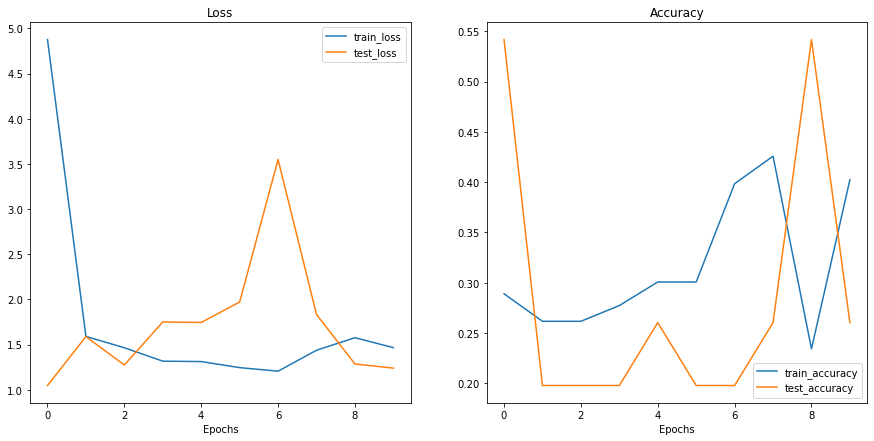

In [48]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

TK - why do the loss curves look the way they do? (too big of a model, not enough data)

## TK 12. Bring in pretrained ViT from `torchvision.models` on same dataset 

* Get a similar model from here - https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16 

In [49]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)

1.12.0+cu102
0.13.0+cu102


In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [51]:
# Set seeds
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [52]:
# Requires torchvision >= 0.13
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Change the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [53]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(128, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                                  [128, 3, 224, 224]   [128, 3]             768                  Partial
├─Conv2d (conv_proj)                                                   [128, 3, 224, 224]   [128, 768, 14, 14]   (590,592)            False
├─Encoder (encoder)                                                    [128, 197, 768]      [128, 197, 768]      151,296              False
│    └─Dropout (dropout)                                               [128, 197, 768]      [128, 197, 768]      --                   --
│    └─Sequential (layers)                                             [128, 197, 768]      [128, 197, 768]      --                   False
│    │    └─EncoderBlock (encoder_layer_0)                             [128, 197, 768]      [128, 197, 768]      (7,087,872)          False
│    │    └─Encod

In [54]:
# TK - the above output has the same number of parameters as our own created model

In [55]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [56]:
train_dir = image_path / "train"
test_dir = image_path / "test" 
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [57]:
# Create dataset for pretrained ViT
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=1024) # From here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [58]:
# Train pretrained feature extractor ViT for 5 epochs on Pizza, Steak, Sushi
# TK - can probably increase the batch_size here because we're using feature extraction and not 
# training the whole model
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1490 | train_acc: 0.2356 | test_loss: 1.0584 | test_acc: 0.4667
Epoch: 2 | train_loss: 1.0017 | train_acc: 0.5289 | test_loss: 0.9194 | test_acc: 0.6400
Epoch: 3 | train_loss: 0.8716 | train_acc: 0.7244 | test_loss: 0.7983 | test_acc: 0.6667
Epoch: 4 | train_loss: 0.7583 | train_acc: 0.8089 | test_loss: 0.6942 | test_acc: 0.7733
Epoch: 5 | train_loss: 0.6608 | train_acc: 0.8622 | test_loss: 0.6060 | test_acc: 0.8800
Epoch: 6 | train_loss: 0.5777 | train_acc: 0.8889 | test_loss: 0.5318 | test_acc: 0.8933
Epoch: 7 | train_loss: 0.5076 | train_acc: 0.9156 | test_loss: 0.4700 | test_acc: 0.9067
Epoch: 8 | train_loss: 0.4487 | train_acc: 0.9244 | test_loss: 0.4188 | test_acc: 0.9333
Epoch: 9 | train_loss: 0.3993 | train_acc: 0.9378 | test_loss: 0.3765 | test_acc: 0.9333
Epoch: 10 | train_loss: 0.3580 | train_acc: 0.9378 | test_loss: 0.3417 | test_acc: 0.9467


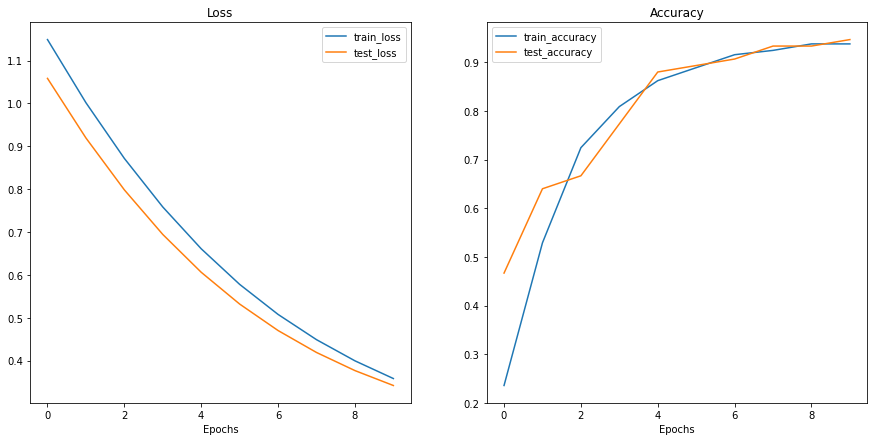

In [59]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

In [60]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [61]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## TK - Things this replication misses out on

TK Put down the difference in the paper vs this replication
* Many of these things are in Table 3:
    * training data (ImageNet from scratch vs FoodVision Mini data) 
    * LR warmup
    * LR decay
    * Weight decay
    * Number of epochs

## TK - Exercises

## TK - Extra-curriculum

* layernorm
* See the illustrated transformer for an overview of the Transformer model:  https://jalammar.github.io/illustrated-transformer/ + https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
* Attention is all you need paper - Yannic video
* Vision transformer - yannic video